In [2]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.time import Time
from astropy.constants import c, G, M_sun
from astropy.coordinates import SkyCoord, solar_system_ephemeris, get_body_barycentric, get_body_barycentric_posvel
from astropy.coordinates import EarthLocation

%matplotlib inline

# Improper Barycentering

If the position of a pulsar is slightly wrong (likely for a new source, since we don't know where it is in the beam!), then the barycentric correction will be slightly wrong.  

This amounts to the source being in a low-velocity, 1-year orbit - this will cause drifting of the frequency bins (< 1 bin, as we will show), but will cause the pulsar to drift out of phase over weeks-months

We can compute
 - The change in frequency
 - The total time delay, and integrated change in phase
 - The inferred 'F1' at any given point
 
## Analytic calculation of residual v_z, induced F1 from position error

For a source with ecliptic latitude and longitude $\beta$, $\lambda$, the radial velocity of the Earth's orbit can be written as

$$v_z \approx v_E \sin( (t-t_{ref}) / T_{year} ) \sin(\beta),$$

where
$$v_E \approx 30km/s$$

The reference time will depend on the ecliptic longitude, something like 
$$t_{ref} = (\theta_{ref} - \lambda) * T_{year}/360^{\circ}$$

When we 'barycenter' the data, it amounts to subtracting off a predicted curve for $v_z$ for a source's given coordinates.  

Incorrect barycentering amounts to subtracting $v_z$ with slightly wrong coordinates $\beta$ or $\lambda$

e.g. for an offset $\Delta \beta$:
$$v_{z, \rm resid} = v_E sin(\theta - \theta_{ref})[ \sin(\beta) - \sin(\beta - \Delta \beta) ]$$

Using the trig identity:
$$\sin(x) - \sin(y) = 2\cos((x+y)/2)\sin((x-y)/2),$$

$$\sin(\beta) - \sin(\beta + \Delta \beta) = 2\cos(\beta + \Delta\beta/2)\sin(\Delta \beta / 2) \approx \Delta \beta \cos(\beta), $$
when $\Delta \beta / 2\pi \ll 1$

Then,
$$v_{z, \rm resid} \approx v_E sin(\theta - \theta_{ref}) \Delta \beta \cos(\beta)$$

One can similarly perturb $\lambda$, using the same trig identity to result in

$$v_{z, \rm resid} \approx v_E cos(\theta - \theta_{ref}) \Delta \lambda \sin(\beta)$$

## Induced F1

The fractional change in the spin frequency is just v/c:
$$ \Delta f / f0 = v/c $$

Then for e.g. a $\Delta \beta$ error:
$$ \frac{\Delta f}{f0} = \frac{v_E}{c} \sin(\theta - \theta_{ref}) \Delta \beta \cos(\beta).$$

$$\frac{df}{dt} = \frac{df}{d\theta} \frac{d\theta}{dt} $$

chain rule left as exercise for the reader, resulting in...

$$ F1 \equiv \frac{df}{dt} = F0 \frac{2\pi}{T_{year}} \frac{v_E}{c} \cos(\theta - \theta_{ref}) \Delta \lambda \sin(\beta)  $$

For a given $F0$, the maximum $F1$ will occur at
$$ F1_{\rm max} = F0 \frac{2\pi}{T_{year}} \frac{v_E}{c} \Delta \beta \cos(\beta) $$

## Proper motion and Parallax

Proper motion will result in a time-increasing position offset -> an annual variation of increasing amplitude

Parallax will result in a time-variable position offset of ~1mas / kpc. This will result in a small, bi-annual variation

In [3]:
from astropy.coordinates import EarthLocation, SkyCoord, solar_system_ephemeris

CHIME_LAT = 49.3211  # degrees
CHIME_LON = -119.6239  # degrees
CHIME_ELEV = 545.0  # meters

# define CHIME's Earth location
CHIME_LOCATION = EarthLocation(
    lat=CHIME_LAT * u.deg, lon=CHIME_LON * u.deg, height=CHIME_ELEV * u.m
)

# use the JPL planetary ephemeris
solar_system_ephemeris.set("jpl")


<ScienceState solar_system_ephemeris: 'jpl'>

In [4]:
def apply_parallax(ra, dec, distance, times):
    """Return unit vectors to source including parallax."""
    # Nominal unit vector
    coord = SkyCoord(ra=ra, dec=dec, frame="icrs")
    n0 = coord.cartesian.get_xyz().value  # shape (3,)
    n0 /= np.linalg.norm(n0)

    # Observer position in AU
    r_obs = get_body_barycentric("earth", times).get_xyz().to(u.AU).value.T  # (N, 3)

    # Transverse displacement
    r_proj = r_obs - (r_obs @ n0)[:, None] * n0

    # Angular shift in radians
    shift = -r_proj / distance.to(u.AU).value

    # Apparent direction
    n_parallax = n0 + shift
    n_parallax /= np.linalg.norm(n_parallax, axis=1)[:, None]

    return n_parallax

def parallax_delay(ra, dec, distance, times):
    """Return geometric delay due to parallax only (μs)."""
    n_nom = SkyCoord(ra=ra, dec=dec, frame="icrs").cartesian.get_xyz().value
    n_nom /= np.linalg.norm(n_nom)

    n_para = apply_parallax(ra, dec, distance, times)
    r_obs = get_body_barycentric("earth", times).get_xyz().to(u.m).value.T

    # Differential delay (n_para - n_nom)
    delta_beta = np.einsum("ij,ij->i", r_obs, n_para - n_nom) * u.m
    return (delta_beta / c).to(u.us)

def predict_barycentric_delay_from_offsets(
    tmjd_range,
    dra=0.0 * u.deg,
    ddec=0.0 * u.deg,
    pmra=0.0 * u.mas/u.yr,
    pmdec=0.0 * u.mas/u.yr,
    distance=1*u.kpc,
    ra=320.0 * u.deg,
    dec=47.0 * u.deg,
    location=EarthLocation.of_site("chime"),
    
):
    """
    Predict timing delay (in microseconds) due to position offset, proper motion, and parallax.
    """
    times = Time(tmjd_range, format="mjd", scale="utc")
    dts = times - times[0]

    # Reference direction with position offset
    coord_ref = SkyCoord(ra=ra + dra, dec=dec + ddec, frame="icrs")
    n_ref = coord_ref.cartesian.get_xyz().value
    n_ref /= np.linalg.norm(n_ref)

    # True coordinate with proper motion (no parallax here)
    coord_true = SkyCoord(
        ra=ra, dec=dec,
        pm_ra_cosdec=pmra,
        pm_dec=pmdec,
        frame="icrs",
        obstime=times[0],
        distance=distance
    )
    coords_true = coord_true.apply_space_motion(dt=dts)
    n_true = coords_true.cartesian.get_xyz().T.value
    n_true /= np.linalg.norm(n_true, axis=1)[:, None]

    # Observer barycentric position
    r_obs = get_body_barycentric("earth", times).get_xyz().to(u.m).value.T

    # Delay from position offset and proper motion
    delta_beta = n_ref - n_true
    dot = np.einsum("ij,ij->i", r_obs, delta_beta) * u.m
    delay_pm_pos = (dot / c).to(u.us)

    # Parallax delay
    delay_parallax = parallax_delay(ra, dec, distance, times)

    # Total delay
    delay_total = delay_pm_pos + delay_parallax

    return delay_total

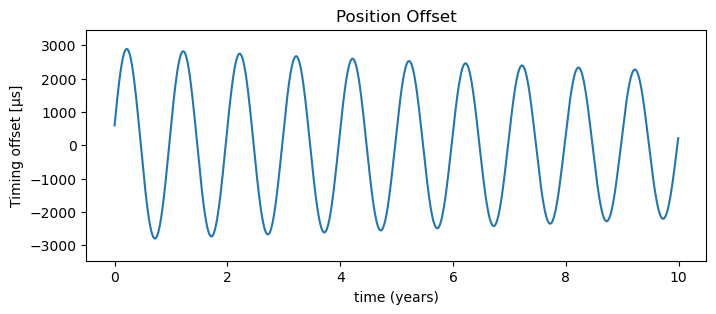

In [10]:
Nyear = 10
dt = np.arange(Nyear*365)*u.day
T0 = Time(50000, format='mjd')
times = T0 + dt
tmjd = times.mjd

# Predict delay
ra=320*u.deg
dec=47*u.deg

# Set the below terms to 0 to isolate effects of pos error, proper motion, parallax
dra=1/3600.*u.deg #* 0
ddec=1/3600.*u.deg #* 0
pmra=20*u.mas/u.yr #* 0
pmdec=20*u.mas/u.yr #* 0
distance=500.*u.pc

delay = predict_barycentric_delay_from_offsets(tmjd, dra=dra, ddec=ddec,
                                  pmra=pmra, pmdec=pmdec, distance=distance,
                                  ra=ra, dec=dec, location=CHIME_LOCATION)
delay -= np.mean(delay)

ymax = np.max(np.abs(delay.to(u.us).value))*1.2
dtyear = dt.to(u.year)

plt.figure(figsize=(8,3))
plt.plot(dtyear, delay.to(u.us).value)
plt.ylim(-ymax, ymax)
plt.ylabel("Timing offset [µs]")
plt.xlabel("time (years)")
plt.title("Position Offset")
plt.show()

# Setting Position offset to zero, to see proper motion

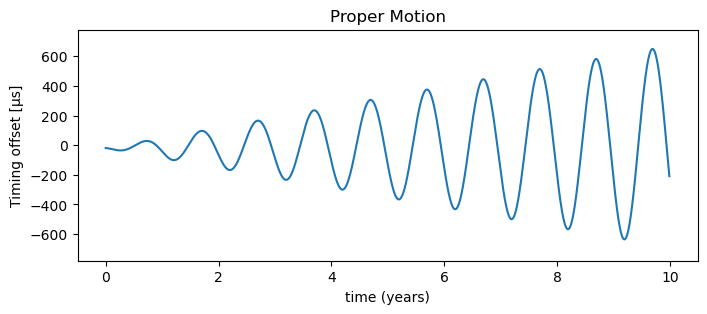

In [11]:
# Set the below terms to 0 to isolate effects of pos error, proper motion, parallax
dra=1/3600.*u.deg * 0
ddec=1/3600.*u.deg * 0
pmra=20*u.mas/u.yr #* 0
pmdec=20*u.mas/u.yr #* 0
distance=500.*u.pc

delay = predict_barycentric_delay_from_offsets(tmjd, dra=dra, ddec=ddec,
                                  pmra=pmra, pmdec=pmdec, distance=distance,
                                  ra=ra, dec=dec, location=CHIME_LOCATION)
delay -= np.mean(delay)

ymax = np.max(np.abs(delay.to(u.us).value))*1.2
dtyear = dt.to(u.year)

plt.figure(figsize=(8,3))
plt.plot(dtyear, delay.to(u.us).value)
plt.ylim(-ymax, ymax)
plt.ylabel("Timing offset [µs]")
plt.xlabel("time (years)")
plt.title("Proper Motion")
plt.show()

# Setting position offset and proper motion to 0, to see parallax

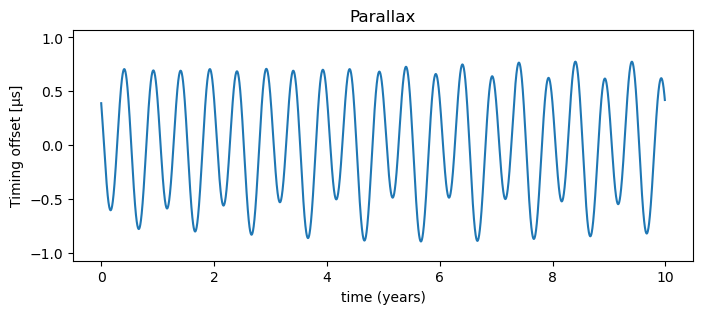

In [14]:
# Set the below terms to 0 to isolate effects of pos error, proper motion, parallax
dra=1/3600.*u.deg * 0
ddec=1/3600.*u.deg * 0
pmra=20*u.mas/u.yr * 0
pmdec=20*u.mas/u.yr * 0
distance=500.*u.pc

delay = predict_barycentric_delay_from_offsets(tmjd, dra=dra, ddec=ddec,
                                  pmra=pmra, pmdec=pmdec, distance=distance,
                                  ra=ra, dec=dec, location=CHIME_LOCATION)
delay -= np.mean(delay)

ymax = np.max(np.abs(delay.to(u.us).value))*1.2
dtyear = dt.to(u.year)

plt.figure(figsize=(8,3))
plt.plot(dtyear, delay.to(u.us).value)
plt.ylim(-ymax, ymax)
plt.ylabel("Timing offset [µs]")
plt.xlabel("time (years)")
plt.title("Parallax")
plt.show()